In [108]:
import yfinance as yf #stock data downloader
import pandas as pd #data manipulation
import numpy as np #statistical calculations
import statsmodels.api as sm #regression analysis
from pandas.tseries.offsets import MonthEnd
from scipy.optimize import minimize
import matplotlib.pyplot as plt



In [77]:
# Tickers
tickers = ['NVDA', 'META', 'WMT', 'SPY', 'TSLA', 'UBER']

# Download daily adjusted prices for the tickers starting from 2015
# auto_adjust=True adjusts for splits/dividends so 'Close' is effectively adjusted close
prices = yf.download(tickers, start="2015-01-01", auto_adjust=True)['Close']

# Compute daily simple returns
returns_daily = prices.pct_change()

# Convert daily returns to monthly frequency:
# - 'M' = month end
# - we take the average of daily returns within each month
#   (you could also use (1+returns).prod()-1 for exact compounded monthly returns)
returns_monthly = returns_daily.resample('M').mean().dropna()


[*********************100%***********************]  6 of 6 completed
/var/folders/gk/2nnj4vd96qx3xfyqlyb38_fr0000gn/T/ipykernel_96324/202837720.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = returns_daily.resample('M').mean().dropna()


In [86]:
# -----------------------------
# Load 3-factor model (your style)
# -----------------------------
url3 = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
ff3_raw = pd.read_csv(url3, skiprows=3)

# Find where the actual factor data ends (before the "Annual Factors" section)
end_row_3f = ff3_raw[ff3_raw.iloc[:,0].astype(str).str.contains("Annual")].index[0]

# Read only the monthly factor rows
ff3 = pd.read_csv(url3, skiprows=3, nrows=end_row_3f-3)

# Set the index to the date (YYYYMM format)
ff3 = ff3.rename(columns={"Unnamed: 0": "Date"})
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')
ff3 = ff3.set_index('Date')

# Convert percent to decimals
ff3 = ff3 / 100

ff3.index = ff3.index + MonthEnd(0)   # shift to month-end


# -----------------------------
# Load 5-factor model (your style)
# -----------------------------
url5 = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5_raw = pd.read_csv(url5, skiprows=3)

end_row_5f = ff5_raw[ff5_raw.iloc[:,0].astype(str).str.contains("Annual")].index[0]

ff5 = pd.read_csv(url5, skiprows=3, nrows=end_row_5f-3)
ff5 = ff5.rename(columns={"Unnamed: 0": "Date"})
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m')
ff5 = ff5.set_index('Date')

ff5 = ff5 / 100

ff5.index = ff5.index + MonthEnd(0)   # shift to month-end


print("FF3 preview:")
print(ff3.head())

print("\nFF5 preview:")
print(ff5.head())


FF3 preview:
            Mkt-RF     SMB     HML      RF
Date                                      
1926-07-31  0.0289 -0.0255 -0.0239  0.0022
1926-08-31  0.0264 -0.0114  0.0381  0.0025
1926-09-30  0.0038 -0.0136  0.0005  0.0023
1926-10-31 -0.0327 -0.0014  0.0082  0.0032
1926-11-30  0.0254 -0.0011 -0.0061  0.0031

FF5 preview:
            Mkt-RF     SMB     HML     RMW     CMA      RF
Date                                                      
1963-07-31 -0.0039 -0.0048 -0.0081  0.0064 -0.0115  0.0027
1963-08-31  0.0508 -0.0080  0.0170  0.0040 -0.0038  0.0025
1963-09-30 -0.0157 -0.0043  0.0000 -0.0078  0.0015  0.0027
1963-10-31  0.0254 -0.0134 -0.0004  0.0279 -0.0225  0.0029
1963-11-30 -0.0086 -0.0085  0.0173 -0.0043  0.0227  0.0027


In [ ]:
# Regression function
def fama_french_expected_return(asset_returns, factors, factor_columns):
    """
    Run a Fama-French regression using YOUR factor tables,
    and compute expected return using mean factor premia.
    """

    # Merge asset returns with factor data, align by date
    df = pd.concat([asset_returns, factors], axis=1).dropna() #note
    
    # Excess returns (Asset - Risk-free)
    y = df.iloc[:,0] - df['RF']
    
    # Design matrix X
    X = df[factor_columns]
    X = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Expected excess return = alpha + sum(beta_i * mean(factor_i))
    exp_excess = model.params['const']
    
    for col in factor_columns:
        exp_excess += model.params[col] * factors[col].mean()
    
    # Add mean risk free rate to get expected total return
    exp_total = exp_excess + factors['RF'].mean()
    
    return model, exp_total


In [ ]:
# Calculate expected returns for each asset using 3F and 5F models

expected_3F = {}
expected_5F = {}
models_3F = {}
models_5F = {}

for ticker in tickers:
    asset_ret = returns_monthly[[ticker]]  # keep as DataFrame
    
    # ----- 3-Factor -----
    mod3, exp3 = fama_french_expected_return(
        asset_ret,
        ff3,
        ['Mkt-RF', 'SMB', 'HML']
    )
    expected_3F[ticker] = exp3
    models_3F[ticker] = mod3

    # ----- 5-Factor -----
    mod5, exp5 = fama_french_expected_return(
        asset_ret,
        ff5,
        ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    )
    expected_5F[ticker] = exp5
    models_5F[ticker] = mod5


3F keys: dict_keys(['META', 'NVDA', 'SPY', 'TSLA', 'UBER', 'WMT'])
5F keys: dict_keys(['META', 'NVDA', 'SPY', 'TSLA', 'UBER', 'WMT'])


In [ ]:
# Expected returns
exp_df = pd.DataFrame({
    '3-Factor Expected Return': expected_3F,
    '5-Factor Expected Return': expected_5F
}).T  # transpose if you want tickers as columns

exp_df


,NVDA,META,WMT,SPY,TSLA,UBER
3-Factor Expected Return,0.003003,0.001441,0.001259,0.001113,0.003209,0.001575
5-Factor Expected Return,0.003860,0.002344,0.002204,0.002021,0.004001,0.002473


In [97]:
# Make sure tickers exactly match the columns in returns_monthly
tickers = list(returns_monthly.columns)

print("Tickers list:", tickers)


Tickers list: ['META', 'NVDA', 'SPY', 'TSLA', 'UBER', 'WMT']


In [ ]:
# Expected return vectors 
mu_3F = np.array([expected_3F[t] for t in tickers])
mu_5F = np.array([expected_5F[t] for t in tickers])

#Covariance matrix of asset returns
cov_matrix = returns_monthly[tickers].cov().values

In [100]:
# RF in ff3 is already monthly (converted to decimal earlier)
rf_monthly = ff3['RF'].mean()   # average monthly risk-free rate over sample


In [101]:
def portfolio_performance(weights, mu, cov, rf):
    """
    Given weights, expected returns (mu), covariance matrix (cov),
    and risk-free rate (rf), return:
    - portfolio expected return
    - portfolio volatility
    - portfolio Sharpe ratio
    All in the same frequency as mu and rf (here: monthly).
    """
    weights = np.array(weights)
    
    # Expected portfolio return
    port_ret = np.dot(weights, mu)
    
    # Portfolio volatility (sqrt(w' Σ w))
    port_vol = np.sqrt(weights @ cov @ weights)
    
    # Sharpe ratio
    sharpe = (port_ret - rf) / port_vol
    
    return port_ret, port_vol, sharpe


def neg_sharpe(weights, mu, cov, rf):
    """Objective function: negative Sharpe (because we minimize)."""
    _, _, sharpe = portfolio_performance(weights, mu, cov, rf)
    return -sharpe


def port_volatility(weights, mu, cov, rf):
    """Objective function for minimum-variance portfolio: just volatility."""
    _, vol, _ = portfolio_performance(weights, mu, cov, rf)
    return vol


In [102]:
def optimize_max_sharpe(mu, cov, rf, allow_short=False):
    """
    Maximize Sharpe ratio given expected returns (mu) and covariance (cov).
    If allow_short=False, weights are constrained to [0, 1].
    """
    n = len(mu)
    x0 = np.ones(n) / n  # start from equal weights
    
    # Constraints: sum(weights) = 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: no shorting => each weight between 0 and 1
    if allow_short:
        bounds = None  # (unbounded; or you could use (-1,1) per asset)
    else:
        bounds = [(0, 1)] * n
    
    result = minimize(
        neg_sharpe,
        x0,
        args=(mu, cov, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x, result  # optimal weights and full result object


def optimize_min_variance(mu, cov, rf, allow_short=False):
    """
    Find minimum-variance portfolio.
    Same constraints as above (sum(weights)=1, optional no-shorting).
    """
    n = len(mu)
    x0 = np.ones(n) / n
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    if allow_short:
        bounds = None
    else:
        bounds = [(0, 1)] * n
    
    result = minimize(
        port_volatility,
        x0,
        args=(mu, cov, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x, result


In [103]:
# --- Max Sharpe portfolios ---

w_maxSharpe_3F, res_ms3 = optimize_max_sharpe(mu_3F, cov_matrix, rf_monthly)
w_maxSharpe_5F, res_ms5 = optimize_max_sharpe(mu_5F, cov_matrix, rf_monthly)

# --- Minimum variance portfolios ---

w_minVar_3F, res_mv3 = optimize_min_variance(mu_3F, cov_matrix, rf_monthly)
w_minVar_5F, res_mv5 = optimize_min_variance(mu_5F, cov_matrix, rf_monthly)


In [104]:
def summarize_portfolio(name, weights, mu, cov, rf):
    ret, vol, sharpe = portfolio_performance(weights, mu, cov, rf)
    return pd.Series({
        'Portfolio': name,
        'Expected Return (monthly)': ret,
        'Volatility (monthly)': vol,
        'Sharpe (monthly)': sharpe
    })

summary = pd.DataFrame([
    summarize_portfolio('3F Max Sharpe', w_maxSharpe_3F, mu_3F, cov_matrix, rf_monthly),
    summarize_portfolio('5F Max Sharpe', w_maxSharpe_5F, mu_5F, cov_matrix, rf_monthly),
    summarize_portfolio('3F Min Var',    w_minVar_3F,    mu_3F, cov_matrix, rf_monthly),
    summarize_portfolio('5F Min Var',    w_minVar_5F,    mu_5F, cov_matrix, rf_monthly),
])

summary


,Portfolio,Expected Return (monthly),Volatility (monthly),Sharpe (monthly)
0,3F Max Sharpe,0.003110,0.006779,0.060823
1,5F Max Sharpe,0.003899,0.006267,0.191751
2,3F Min Var,0.001186,0.002158,-0.700198
3,5F Min Var,0.002113,0.002158,-0.270792


In [106]:
summary['Exp Return (annual)'] = (1 + summary['Expected Return (monthly)'])**12 - 1
summary['Volatility (annual)'] = summary['Volatility (monthly)'] * np.sqrt(12)
summary['Sharpe (annual)'] = (summary['Exp Return (annual)'] - rf_monthly*12) / summary['Volatility (annual)']
summary

,Portfolio,Expected Return (monthly),Volatility (monthly),Sharpe (monthly),Exp Return (annual),Volatility (annual),Sharpe (annual)
0,3F Max Sharpe,0.003110,0.006779,0.060823,0.037960,0.023484,0.238155
1,5F Max Sharpe,0.003899,0.006267,0.191751,0.047803,0.021709,0.711068
2,3F Min Var,0.001186,0.002158,-0.700198,0.014325,0.007476,-2.413091
3,5F Min Var,0.002113,0.002158,-0.270792,0.025650,0.007476,-0.898366


In [107]:
weights_df = pd.DataFrame({
    'Ticker': tickers,
    '3F Max Sharpe': w_maxSharpe_3F,
    '5F Max Sharpe': w_maxSharpe_5F,
    '3F Min Var': w_minVar_3F,
    '5F Min Var': w_minVar_5F
}).set_index('Ticker')

weights_df


,3F Max Sharpe,5F Max Sharpe,3F Min Var,5F Min Var
Ticker,,,,
META,0.000000e+00,1.999835e-17,0.000000e+00,0.000000e+00
NVDA,4.824156e-01,7.259834e-01,2.363561e-17,2.363561e-17
SPY,9.640920e-17,0.000000e+00,5.003153e-01,5.003153e-01
TSLA,5.175844e-01,2.740166e-01,0.000000e+00,0.000000e+00
UBER,1.968091e-17,0.000000e+00,4.228388e-18,4.228388e-18
WMT,2.890375e-17,3.488070e-17,4.996847e-01,4.996847e-01


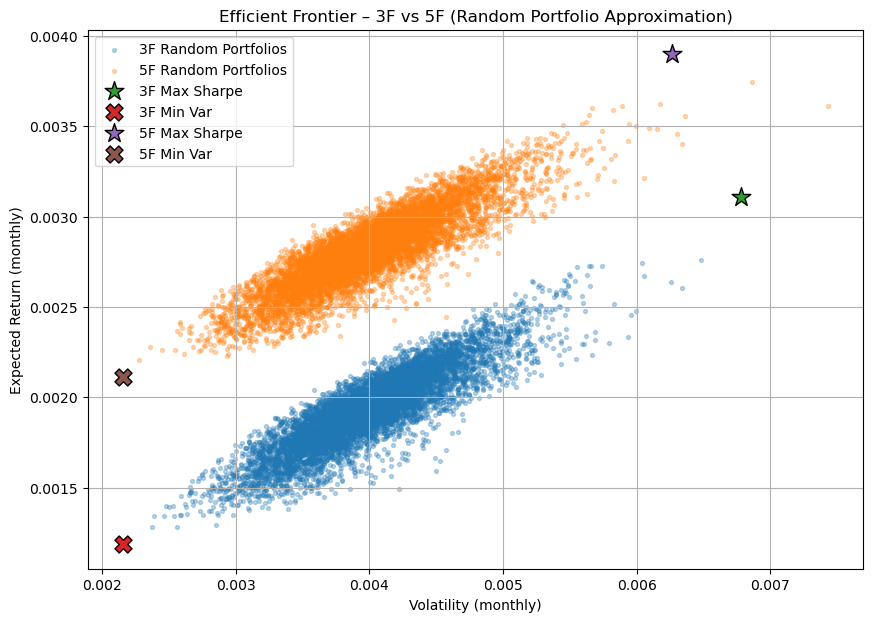

In [111]:
# ---------- Helper: generate random portfolios ----------

def generate_random_portfolios(mu, cov, rf, n_portfolios=10000):
    """
    Generate random portfolios to approximate the efficient frontier.
    Returns arrays of (returns, volatilities, sharpes).
    """
    n_assets = len(mu)
    rets = []
    vols = []
    sharpes = []
    
    for _ in range(n_portfolios):
        # random weights that sum to 1 (no shorting)
        w = np.random.rand(n_assets)
        w /= w.sum()
        
        # portfolio performance
        port_ret = np.dot(w, mu)
        port_vol = np.sqrt(w @ cov @ w)
        sharpe = (port_ret - rf) / port_vol
        
        rets.append(port_ret)
        vols.append(port_vol)
        sharpes.append(sharpe)
    
    return np.array(rets), np.array(vols), np.array(sharpes)

# ---------- Generate random portfolios for 3F and 5F ----------

rets_3F, vols_3F, sharpe_3F = generate_random_portfolios(mu_3F, cov_matrix, rf_monthly, n_portfolios=8000)
rets_5F, vols_5F, sharpe_5F = generate_random_portfolios(mu_5F, cov_matrix, rf_monthly, n_portfolios=8000)

# ---------- Compute performance of the 4 optimal portfolios ----------

ret_ms3, vol_ms3, sh_ms3 = portfolio_performance(w_maxSharpe_3F, mu_3F, cov_matrix, rf_monthly)
ret_ms5, vol_ms5, sh_ms5 = portfolio_performance(w_maxSharpe_5F, mu_5F, cov_matrix, rf_monthly)

ret_mv3, vol_mv3, sh_mv3 = portfolio_performance(w_minVar_3F, mu_3F, cov_matrix, rf_monthly)
ret_mv5, vol_mv5, sh_mv5 = portfolio_performance(w_minVar_5F, mu_5F, cov_matrix, rf_monthly)

# ---------- Plot efficient frontiers + highlighted points ----------

plt.figure(figsize=(10, 7))

# Scatter of random portfolios (approximate frontiers)
plt.scatter(vols_3F, rets_3F, s=8, alpha=0.3, label='3F Random Portfolios')
plt.scatter(vols_5F, rets_5F, s=8, alpha=0.3, label='5F Random Portfolios')

# Highlight optimal portfolios
plt.scatter(vol_ms3, ret_ms3, marker='*', s=200, edgecolor='k', label='3F Max Sharpe')
plt.scatter(vol_mv3, ret_mv3, marker='X', s=150, edgecolor='k', label='3F Min Var')

plt.scatter(vol_ms5, ret_ms5, marker='*', s=200, edgecolor='k', label='5F Max Sharpe')
plt.scatter(vol_mv5, ret_mv5, marker='X', s=150, edgecolor='k', label='5F Min Var')

plt.xlabel('Volatility (monthly)')
plt.ylabel('Expected Return (monthly)')
plt.title('Efficient Frontier – 3F vs 5F (Random Portfolio Approximation)')
plt.legend()
plt.grid(True)
plt.show()


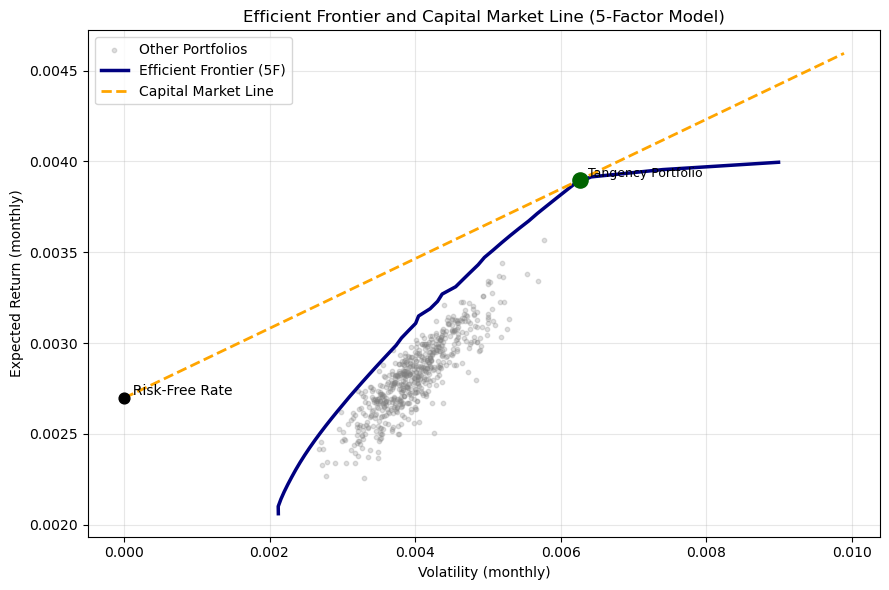

In [113]:
# --- Helper: min-vol objective (same as before) ---
def port_volatility(weights, mu, cov, rf):
    weights = np.array(weights)
    return np.sqrt(weights @ cov @ weights)

# --- Build a smooth efficient frontier for the 5F model ---
def efficient_frontier(mu, cov, n_points=50, allow_short=False):
    """
    Compute a smooth efficient frontier by minimizing variance
    for a range of target returns.
    Returns arrays of (vols, rets).
    """
    n = len(mu)
    mu = np.array(mu)
    
    # Target returns span from near min(mu) to max(mu)
    target_returns = np.linspace(mu.min()*0.8, mu.max()*1.2, n_points)
    
    vols = []
    rets = []
    
    for target in target_returns:
        # initial guess: equal weights
        x0 = np.ones(n) / n
        
        # constraints: sum w = 1, expected return = target
        cons = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, t=target: np.dot(w, mu) - t}
        )
        
        if allow_short:
            bounds = None
        else:
            bounds = [(0, 1)] * n
        
        res = minimize(
            port_volatility,
            x0,
            args=(mu, cov, 0.0),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )
        
        if res.success:
            w_opt = res.x
            vol_opt = np.sqrt(w_opt @ cov @ w_opt)
            vols.append(vol_opt)
            rets.append(np.dot(w_opt, mu))
    
    return np.array(vols), np.array(rets)

# ---- Build frontier and random inferior portfolios (5F only) ----
vols_frontier_5F, rets_frontier_5F = efficient_frontier(mu_5F, cov_matrix, n_points=80)

# random portfolios just for “inferior” points
def random_portfolios(mu, cov, rf, n_portfolios=500):
    n = len(mu)
    rets = []
    vols = []
    for _ in range(n_portfolios):
        w = np.random.rand(n)
        w /= w.sum()
        rets.append(np.dot(w, mu))
        vols.append(np.sqrt(w @ cov @ w))
    return np.array(vols), np.array(rets)

vols_rand_5F, rets_rand_5F = random_portfolios(mu_5F, cov_matrix, rf_monthly, 600)

# --- 5F tangency (max Sharpe) portfolio stats ---
ret_ms5, vol_ms5, sh_ms5 = portfolio_performance(w_maxSharpe_5F, mu_5F, cov_matrix, rf_monthly)

# --- Capital Market Line for 5F ---
max_vol_for_line = max(vols_frontier_5F.max(), vols_rand_5F.max(), vol_ms5) * 1.1
vol_range = np.linspace(0, max_vol_for_line, 100)
cml_5F = rf_monthly + sh_ms5 * vol_range

# --- Plot in a clean, professional style ---
plt.figure(figsize=(9, 6))

# inferior/random portfolios
plt.scatter(vols_rand_5F, rets_rand_5F,
            s=10, alpha=0.25, color='gray', label='Other Portfolios')

# efficient frontier curve
plt.plot(vols_frontier_5F, rets_frontier_5F,
         linewidth=2.5, label='Efficient Frontier (5F)', color='navy')

# Capital Market Line
plt.plot(vol_range, cml_5F,
         linewidth=2, linestyle='--', color='orange', label='Capital Market Line')

# risk-free point
plt.scatter(0, rf_monthly, color='black', s=60, zorder=5)
plt.text(0, rf_monthly, "  Risk-Free Rate", va='bottom', ha='left')

# tangency (max-Sharpe) portfolio
plt.scatter(vol_ms5, ret_ms5, color='darkgreen', s=120, zorder=6)
plt.text(vol_ms5, ret_ms5,
         "  Tangency Portfolio",
         va='bottom', ha='left', fontsize=9)

# axes & labels
plt.xlabel('Volatility (monthly)')
plt.ylabel('Expected Return (monthly)')
plt.title('Efficient Frontier and Capital Market Line (5-Factor Model)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


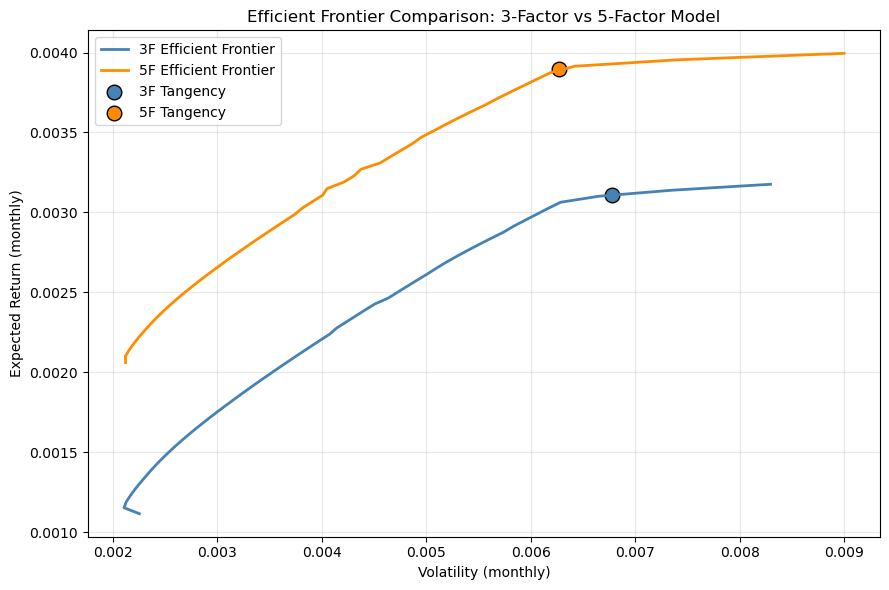

In [114]:

# --- Efficient frontier helper (reuse from before if already defined) ---
def port_volatility(weights, mu, cov, rf=0.0):
    weights = np.array(weights)
    return np.sqrt(weights @ cov @ weights)

def efficient_frontier(mu, cov, n_points=50, allow_short=False):
    """
    Compute a smooth efficient frontier by minimizing variance
    for a grid of target returns.
    """
    n = len(mu)
    mu = np.array(mu)

    # Target returns from slightly below min to slightly above max
    target_returns = np.linspace(mu.min()*0.8, mu.max()*1.2, n_points)

    vols = []
    rets = []

    for target in target_returns:
        x0 = np.ones(n) / n

        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, t=target: np.dot(w, mu) - t}
        )

        bounds = None if allow_short else [(0, 1)] * n

        res = minimize(
            port_volatility,
            x0,
            args=(mu, cov, 0.0),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        if res.success:
            w_opt = res.x
            vol_opt = np.sqrt(w_opt @ cov @ w_opt)
            vols.append(vol_opt)
            rets.append(np.dot(w_opt, mu))

    return np.array(vols), np.array(rets)

# --- Build frontiers for 3F and 5F ---

vols_frontier_3F, rets_frontier_3F = efficient_frontier(mu_3F, cov_matrix, n_points=80)
vols_frontier_5F, rets_frontier_5F = efficient_frontier(mu_5F, cov_matrix, n_points=80)

# Tangency (max Sharpe) points for each model
ret_ms3, vol_ms3, sh_ms3 = portfolio_performance(w_maxSharpe_3F, mu_3F, cov_matrix, rf_monthly)
ret_ms5, vol_ms5, sh_ms5 = portfolio_performance(w_maxSharpe_5F, mu_5F, cov_matrix, rf_monthly)

# --- Plot: 3F vs 5F efficient frontiers only ---

plt.figure(figsize=(9, 6))

plt.plot(vols_frontier_3F, rets_frontier_3F,
         linewidth=2, color='steelblue', label='3F Efficient Frontier')

plt.plot(vols_frontier_5F, rets_frontier_5F,
         linewidth=2, color='darkorange', label='5F Efficient Frontier')

# Highlight tangency portfolios
plt.scatter(vol_ms3, ret_ms3, color='steelblue', s=110, marker='o', edgecolor='k', label='3F Tangency')
plt.scatter(vol_ms5, ret_ms5, color='darkorange', s=110, marker='o', edgecolor='k', label='5F Tangency')

plt.xlabel('Volatility (monthly)')
plt.ylabel('Expected Return (monthly)')
plt.title('Efficient Frontier Comparison: 3-Factor vs 5-Factor Model')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
